# Assessing style preservation in MT-communication

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from collections import Counter
from scipy.stats import chisquare

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import pipeline

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
### Utils 

# load model 
def load_classifier(base_model, model_path, task):
  tokenizer = BertTokenizer.from_pretrained(base_model, padding=True, truncation=True)
  model = BertForSequenceClassification.from_pretrained(model_path)
  clf = pipeline(task, model=model, tokenizer=tokenizer, truncation=True, device=0)
  return clf

def predict_style_label(df, col, base_model, model_path, task='text-classification'):
  clf = load_classifier(base_model, model_path, task)
  preds = clf(list(df[col]))
  return [pred['label'].strip('LABEL_') for pred in preds]

def get_sorted_cnts(labels, num_class):
  cnts = sorted(Counter(labels).items())
  return [v for k,v in cnts][:num_class]

def plot_distribution(name, sorted_cnts, num_class, original_cnt, \
                      ymax, xlabels=None, interval=500, savefig=False, color='b', \
                      ftsize=25, width=0.9, alpha=0.8):  
  plt.ylim(0, ymax)
  if xlabels:
    plt.xticks(ticks=range(0, num_class), labels=xlabels, fontsize=ftsize)
  else:   
    plt.xticks(fontsize=ftsize)
  plt.yticks(range(0, ymax, interval), fontsize=ftsize)

  plt.bar(range(num_class), sorted_cnts, color=color, align='center', width=width, alpha=alpha)
  plt.axhline(y=original_cnt, color='k', linestyle='--')
  plt.text(-0.5, 0.8*ymax, r'$\chi^2$ test:'+get_sig_test_stars(sorted_cnts), fontsize=ftsize)
  if savefig: 
    plt.savefig(f"{name}.png", format="png", bbox_inches="tight")

def get_sig_test_stars(sorted_cnts):
  _, pval = chisquare(sorted_cnts)
  if pval <= 0.001:
    return "***"
  elif pval <= 0.01:
    return "**"
  elif pval <= 0.05:
    return "*"
  else:
    return "p > 0.5"

### Formality 

Our diagnostic test dataset is sampled from the [Enron corpus](https://www.cs.cmu.edu/~enron/). We use a collection of utterances processed by Madaan et al. and released with [Politeness Transfer: A Tag and Generate Approach](https://github.com/tag-and-generate/politeness-dataset). 

In [ ]:
df_formality = pd.read_json("drive/MyDrive/Assessing-MT/data/formality_samples.json")

In [ ]:
formality_preds = {}
for col in ['zh-en', 'de-en', 'it-en']:
  formality_preds[col] = predict_style_label(df_formality, col, 'bert-base-uncased', 'drive/MyDrive/Assessing-MT/models/formality-email')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

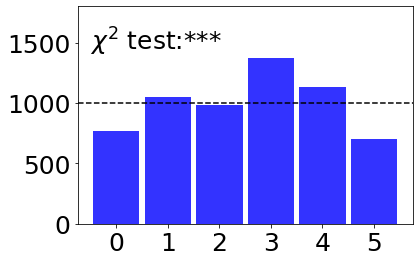

In [ ]:
zh_translations = get_sorted_cnts(formality_preds['zh-en'], 6) 
plot_distribution('formality-zh', zh_translations, 6, 1000, 1800, color='b')

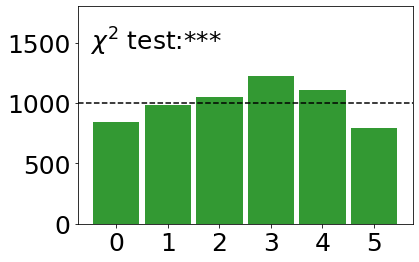

In [ ]:
de_translations = get_sorted_cnts(formality_preds['de-en'], 6) 
plot_distribution('formality-de', de_translations, 6, 1000, 1800, color='g')

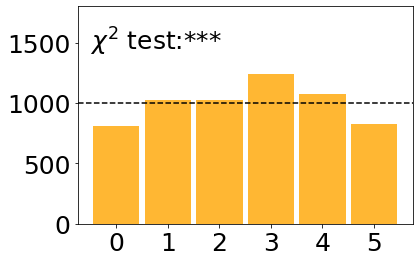

In [ ]:
it_translations = get_sorted_cnts(formality_preds['it-en'], 6) 
plot_distribution('formality-it', it_translations, 6, 1000, 1800, color='orange')

### Politeness 

In [ ]:
df_politeness_en = pd.read_json("drive/MyDrive/Assessing-MT/data/twcs_samples.json")
df_politeness_zh = pd.read_json("drive/MyDrive/Assessing-MT/data/lccc_samples.json")

In [ ]:
tweets_trans_labels = predict_style_label(df_politeness_en, 'en-zh', 'bert-base-chinese', 'drive/MyDrive/Assessing-MT/models/politeness-weibo')
tweets_backtrans_labels = predict_style_label(df_politeness_en, 'zh-en', 'bert-base-uncased', 'drive/MyDrive/Assessing-MT/models/politeness-twitter')

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

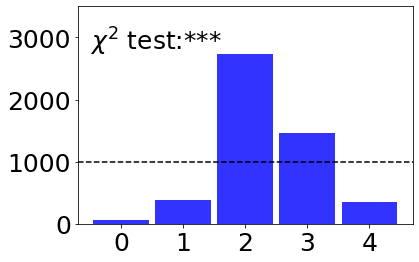

In [ ]:
tweets_trans_cnts = get_sorted_cnts(tweets_trans_labels, 5)
plot_distribution('politeness-en-translation', tweets_trans_cnts, 5, 1000, 3500, interval=1000, savefig=True, color='blue')

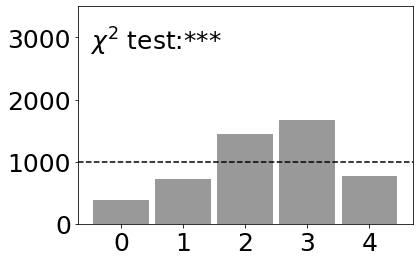

In [ ]:
tweets_backtrans_cnts = get_sorted_cnts(tweets_backtrans_labels, 5)
plot_distribution('politeness-en-backtrans', tweets_backtrans_cnts, 5, 1000, 3500, interval=1000, savefig=True, color='gray')

In [ ]:
weibo_trans_labels = predict_style_label(df_politeness_zh, 'zh-en', 'bert-base-uncased', 'drive/MyDrive/Assessing-MT/models/politeness-twitter')
weibo_backtrans_labels = predict_style_label(df_politeness_zh, 'en-zh', 'bert-base-chinese', 'drive/MyDrive/Assessing-MT/models/politeness-weibo')

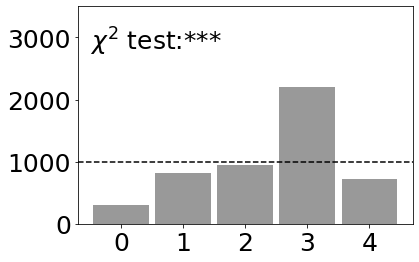

In [ ]:
weibo_trans_cnts = get_sorted_cnts(weibo_trans_labels, 5)
plot_distribution('politeness-zh-translation', weibo_trans_cnts, 5, 1000, 3500, interval=1000, savefig=True, color='gray')

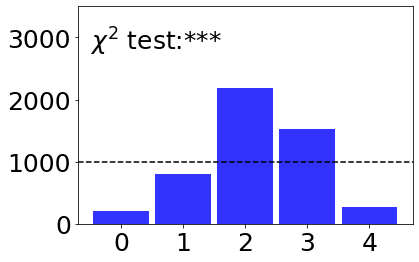

In [ ]:
weibo_backtrans_cnts = get_sorted_cnts(weibo_backtrans_labels, 5)
plot_distribution('politeness-zh-backtrans', weibo_backtrans_cnts, 5, 1000, 3500, interval=1000, savefig=True, color='blue')

### Sentiment

In [ ]:
df_sentiment = pd.read_json("drive/MyDrive/Assessing-MT/data/review_samples.json")

In [ ]:
sentiment_preds = {}
for col in ['en-fr', 'en-de', 'en-it']:
  sentiment_preds[col] = predict_style_label(df_sentiment, col, 'nlptown/bert-base-multilingual-uncased-sentiment', 'nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
labels = list(range(1, 6))

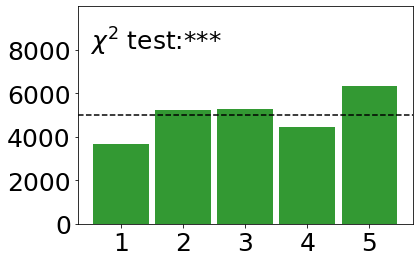

In [ ]:
sentiment_de_translations = get_sorted_cnts(sentiment_preds['en-de'], 5) 
plot_distribution('sentiment-de', sentiment_de_translations, 5, 5000, 10000, xlabels=labels, interval=2000, savefig=True, color='green')

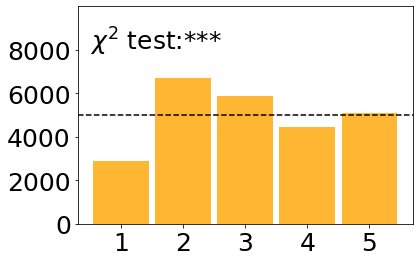

In [ ]:
sentiment_it_translations = get_sorted_cnts(sentiment_preds['en-it'], 5) 
plot_distribution('sentiment-it', sentiment_it_translations, 5, 5000, 10000, xlabels=labels, interval=2000, savefig=True, color='orange')

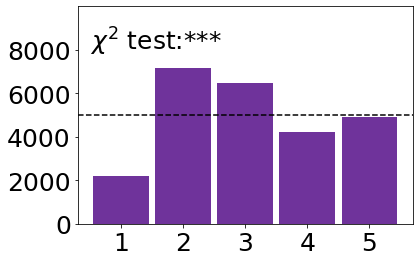

In [ ]:
sentiment_fr_translations = get_sorted_cnts(sentiment_preds['en-fr'], 5) 
plot_distribution('sentiment-fr', sentiment_fr_translations, 5, 5000, 10000, xlabels=labels, interval=2000, savefig=True, color='indigo')